In [ ]:
# Hitters Cluster Analysis

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# Reading in Data
hitters = pd.read_csv('Hitters.csv')
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [ ]:
# Feature Selection - Removed categorical variables and Salary
X = hitters.drop(columns = ['Salary', 'League', 'Division', 'NewLeague']).dropna()

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

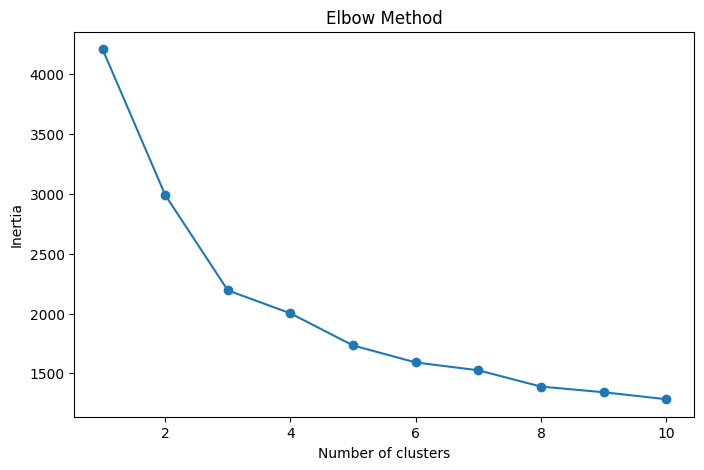

In [ ]:
# Elbow Method for Optimal Number of Clusters (K)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Elbow method plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()
#k=3, 4, or 5 seem like good options, there stops being a drastic change around k=3

In [ ]:
# Silhouette Score to determine number of clusters
scores = []
for k in range(2, 10):  
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append((k, score))

print(scores)
#K=3 is best for cluster amount, it has the highest silhouette score while keeping the amount of clusters low

[(2, 0.2736891147512909), (3, 0.27624556979855547), (4, 0.2602841804472285), (5, 0.274232459531468), (6, 0.21675845823250642), (7, 0.22093483036605935), (8, 0.21480243860503043), (9, 0.20172996412256916)]


In [ ]:
# K-means with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Added clusters as attribute
hitters['Cluster'] = kmeans.labels_

In [21]:
# Interpreting Clusters
#Numeric Columns
feature_cols = [c for c in hitters.columns if c not in ['Salary','League','Division','NewLeague','Cluster']]

#Feature means
cluster_means = hitters.groupby('Cluster')[feature_cols].mean().round(1)
display(cluster_means)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
Cluster,,,,,,,,,,,,,,,,
0,427.8,113.8,16.3,59.2,64.8,52.6,14.7,6663.4,1843.6,214.1,945.8,933.6,724.8,314.5,77.2,6.8
1,274.4,69.6,6.3,33.6,31.4,26.1,5.8,1466.9,379.8,28.5,181.3,156.1,130.5,211.3,69.6,6.3
2,525.2,144.3,15.1,74.4,66.3,51.6,5.7,2201.1,603.7,50.4,300.9,256.6,198.9,361.7,186.1,11.7


In [ ]:
# Average salary of each cluster
salary_means = hitters.groupby('Cluster')['Salary'].mean().round(0)
print(salary_means)

#Salary differences even though not used to create cluster - forms naturally
#Cluster 0: Veterans - high totals, high years of experience, highest salaries
#Cluster 1: Younger or Role Players - less atbats and hits (low playing time), low career totals, lowest salaries
#Cluster 2: Regulars - higher career totals than cluster 2 - same experience average but play more regularly, midrange stats, midrange salaries

Cluster
0    929.0
1    299.0
2    613.0
Name: Salary, dtype: float64


C:\Users\amina\AppData\Local\Temp\ipykernel_22640\2366997697.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Salary", data=hitters, palette= 'Set2')


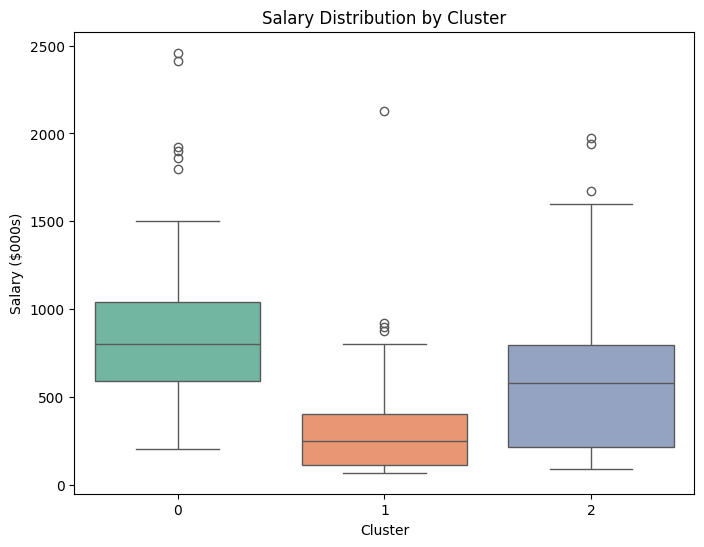

In [ ]:
# Salary distribution by cluster plot
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="Salary", data=hitters, palette= 'Set2')
plt.title("Salary Distribution by Cluster")
plt.ylabel("Salary ($000s)")
plt.xlabel("Cluster")
plt.show()

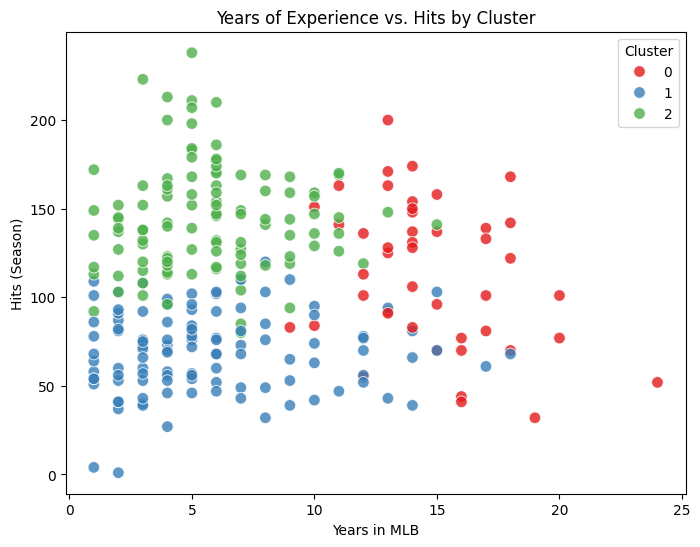

In [ ]:
# Years vs Hits plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Years", y="Hits", 
    hue="Cluster", palette="Set1",
    data=hitters, s=70, alpha=0.8
)
plt.title("Years of Experience vs. Hits by Cluster")
plt.xlabel("Years in MLB")
plt.ylabel("Hits (Season)")
plt.legend(title="Cluster")
plt.show()

In [ ]:
# PCA analysis
pca = PCA()
pca.fit(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative = np.cumsum(explained_variance)
print(cumulative)
#PC3 best option- explains 81.8% of variation
#Will use PC1 vs PC2 for modeling - these explain 71% of variation

[0.45311913 0.70998464 0.81798318 0.87238195 0.91596762 0.94799095
 0.96372127 0.97528009 0.98355667 0.98967987 0.99351456 0.99695435
 0.99871587 0.99961897 0.99992487 1.        ]


In [ ]:
# Determining what features most make up PC1 and PC2

#Feature columns
feature_cols = [c for c in hitters.columns if c not in ['Salary','League','Division','NewLeague','Cluster']]

#PCA loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=feature_cols
)

#Features sorted by importance
print("Top features for PC1:")
print(loadings['PC1'].sort_values(key=abs, ascending=False).head(5))

print("\nTop features for PC2:")
print(loadings['PC2'].sort_values(key=abs, ascending=False).head(5))


Top features for PC1:
CRBI      0.342675
CRuns     0.340501
CHits     0.333577
CAtBat    0.333319
CHmRun    0.320087
Name: PC1, dtype: float64

Top features for PC2:
AtBat    0.391118
Hits     0.383922
Runs     0.381179
RBI      0.318169
Years   -0.259716
Name: PC2, dtype: float64


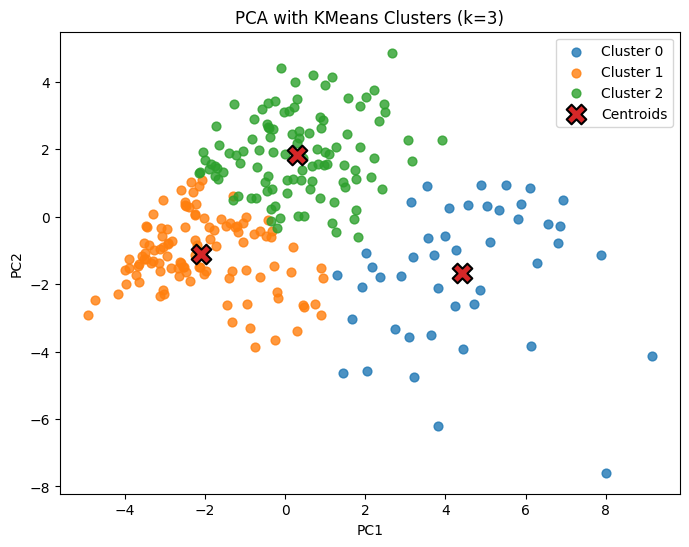

In [ ]:
# PCA cluster graph
pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for c in np.unique(hitters['Cluster']):
    idx = hitters['Cluster'] == c
    plt.scatter(Xp[idx, 0], Xp[idx, 1], s=40, alpha=0.8, label=f'Cluster {c}')

#Cluster centroids 
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], s=200, marker='X',
            edgecolor='black', linewidth=1.5, label='Centroids')

plt.title('PCA with KMeans Clusters (k=3)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()
